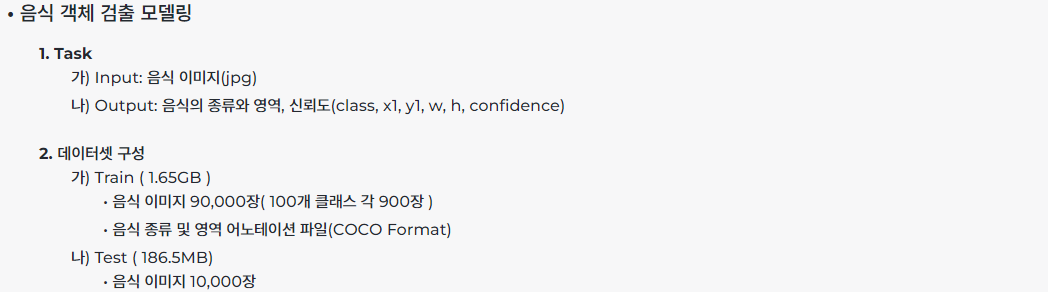

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


음식데이터 9만장과 그에 해당하는 주석파일을 다운로드

In [2]:
!wget https://kr.object.ncloudstorage.com/aihub-competition/dataset/Food_Train.zip
!unzip -qq Food_Train.zip
!wget https://kr.object.ncloudstorage.com/aihub-competition/dataset/food_train_anno.json

--2023-04-27 04:33:51--  https://kr.object.ncloudstorage.com/aihub-competition/dataset/Food_Train.zip
Resolving kr.object.ncloudstorage.com (kr.object.ncloudstorage.com)... 1.255.58.138
Connecting to kr.object.ncloudstorage.com (kr.object.ncloudstorage.com)|1.255.58.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1773250355 (1.7G) [application/zip]
Saving to: ‘Food_Train.zip’

Food_Train.zip      100%[===================>]   1.65G  17.6MB/s    in 1m 41s  

2023-04-27 04:35:34 (16.7 MB/s) - ‘Food_Train.zip’ saved [1773250355/1773250355]

--2023-04-27 04:36:05--  https://kr.object.ncloudstorage.com/aihub-competition/dataset/food_train_anno.json
Resolving kr.object.ncloudstorage.com (kr.object.ncloudstorage.com)... 1.255.58.139
Connecting to kr.object.ncloudstorage.com (kr.object.ncloudstorage.com)|1.255.58.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42767383 (41M) [application/json]
Saving to: ‘food_train_anno.json’

food_tr

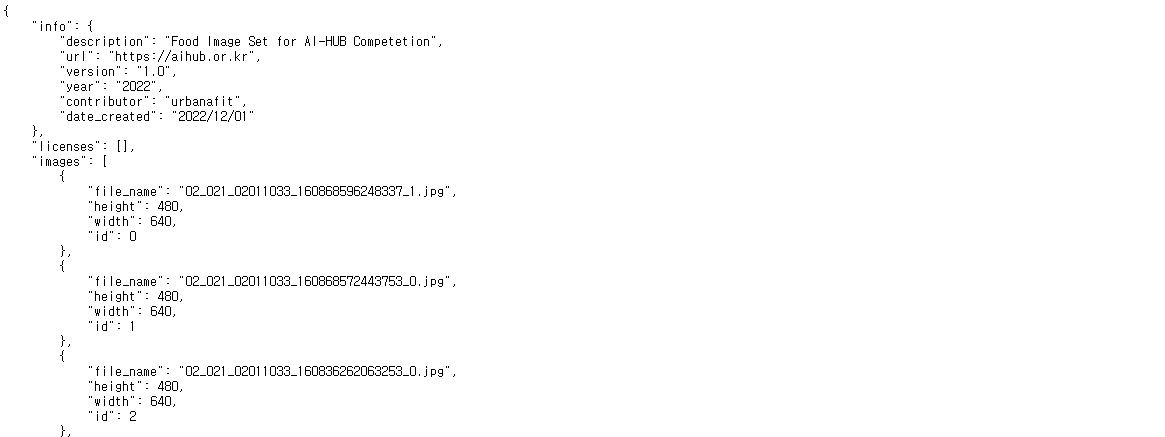

In [3]:
import time
import os
import math
import datetime
import json
import time

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils import data
from torchvision import datasets, transforms

In [4]:
class KFoodDataset(datasets.CocoDetection):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        super().__init__(root, annFile, transform, target_transform)
                 
    def _load_image(self, id: int):             # 주어진 id에 해당하는 이미지를 로드하고 RGB 형식의 numpy 배열로 반환
        path = self.coco.loadImgs(id)[0]["file_name"]
        return np.array(Image.open(os.path.join(self.root, path)).convert("RGB"))
    
    def _load_target(self, id: int):         # 주어진 id에 해당하는 주석을 로드하고 bounding box와 레이블 정보를 추출하여 반환
        anns = self.coco.loadAnns(self.coco.getAnnIds(id))
        boxes = anns[0]['bbox']
        
        boxes[2] = boxes[0]+boxes[2]
        boxes[3] = boxes[1]+boxes[3]
        
        labels = anns[0]['category_id']
        
        return {'boxes': boxes, 'labels':labels}

    def _rearragne_bbox(self, bbox):     # bounding box의 좌표 형식을 (x1,y1,x2,y2)에서 (x1,y1,w,h)로 변경
        x1, y1, w, h = bbox
        return x1, y1,x1+w, y1+h

    
    def __getitem__(self, index):        # 주어진 인덱스에 해당하는 이미지와 타겟을 반환합니다
        id = self.ids[index] 
        image = self._load_image(id)
        target = self._load_target(id)
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)     
            
        target['boxes'] = torch.Tensor([target['boxes']]).to(torch.int)       # 텐서로 변환하여 반환
        target['labels'] = torch.Tensor([target['labels']]).to(torch.int64)   # 텐서로 변환하여 반환     
        
        return image, target

# 샘플을 그룹화하는 함수
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
# 이미지 전처리 단계
transform = transforms.Compose([
    transforms.ToTensor(),                      # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화
])

kfood_dataset = KFoodDataset(
    root = '/content/Train/',
    annFile = './food_train_anno.json',  
    transform = transform,
)

epochs = 1
batch_size = 8
num_classes = len(kfood_dataset.coco.cats)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 데이터셋 미니배치 단위로 불러오는 데이터 로더
tr_loader = torch.utils.data.DataLoader(
    kfood_dataset,
    batch_size=batch_size,
    collate_fn = collate_fn
)

# faster r-cnn
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(num_classes = num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 103MB/s]


In [6]:
# id에 해당하는 이름 매칭된 것 확인
kfood_dataset.coco.cats

{0: {'id': 0, 'name': 'Potato Rice'},
 1: {'id': 1, 'name': 'Gondrebab'},
 2: {'id': 2, 'name': 'Rice ball'},
 3: {'id': 3, 'name': 'Fried rice'},
 4: {'id': 4, 'name': 'Albab'},
 5: {'id': 5, 'name': 'pine mushroom rice'},
 6: {'id': 6, 'name': 'Japtangbap'},
 7: {'id': 7, 'name': 'Sundae gukbap'},
 8: {'id': 8, 'name': 'Jeonju Bean Sprout Soup'},
 9: {'id': 9, 'name': 'Rice with Sashimi'},
 10: {'id': 10, 'name': 'Pork and rice soup'},
 11: {'id': 11, 'name': 'hayashi Rice'},
 12: {'id': 12, 'name': 'Kimchi Gimbap'},
 13: {'id': 13, 'name': 'Octopus sushi'},
 14: {'id': 14, 'name': 'Shrimp sushi'},
 15: {'id': 15, 'name': 'Ribs Triangular Gimbap'},
 16: {'id': 16, 'name': 'Regular Gimbap'},
 17: {'id': 17, 'name': 'Chicken Kalguksu'},
 18: {'id': 18, 'name': 'Black Bean Noodles'},
 19: {'id': 19, 'name': 'Jjamppong'},
 20: {'id': 20, 'name': 'Kongguksu'},
 21: {'id': 21, 'name': 'Tteokguk'},
 22: {'id': 22, 'name': 'Black Bean Noodles'},
 23: {'id': 23, 'name': 'Meat Dumpling'},
 24:

In [7]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def plot_image_from_input(img,i):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    xmin, ymin, xmax, ymax = kfood_dataset._load_target(i)['boxes']
    rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='red',facecolor='none')
    ax.add_patch(rect)

    plt.show()

{'boxes': tensor([[211, 199, 394, 427]], dtype=torch.int32), 'labels': tensor([92])}


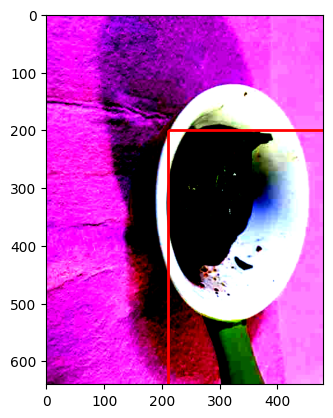

{'boxes': tensor([[ 77,  76, 408, 585]], dtype=torch.int32), 'labels': tensor([92])}


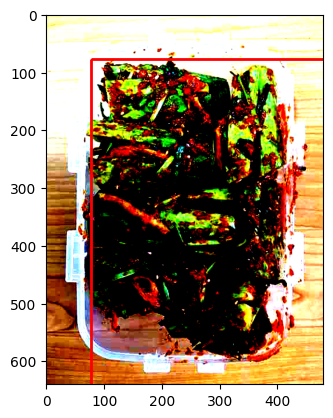

In [8]:
for i in range(10100,10102):
  print(kfood_dataset.__getitem__(i)[1])
  plot_image_from_input(kfood_dataset.__getitem__(i)[0],i)

In [ ]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    idx = 0
    total_idx = 0
    # 미니배치 단위로 데이터를 로드
    for image,target in tqdm(tr_loader):
        idx+=1
        image = tuple(i.to(device) for i in image)
        target = tuple({k:v.to(device) for k,v in anno.items()} for anno in target)
        
        loss_dict = model(image, target) # 손실을 계산
        losses = sum(l for l in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss+=losses
        
        if idx%1000==0:
            
            print(f"[INFO] Epoch {epoch}/{epochs} in Step {idx}/{len(tr_loader)}")
            print(f"[INFO] Total Loss: {epoch_loss/(idx):.4f}, Step Loss: {losses:.4f}")

            elapsed_time = time.time()-start_time
            elapsed_time_str = f"{str(int(elapsed_time//3600)).zfill(2)}H {str(int((elapsed_time%3600)//60)).zfill(2)}M {elapsed_time%60:.2f}S"
            
            estimaed_time = (time.time()-start_time)*(len(tr_loader)/idx)
            estimaed_time_str = f"{str(int(estimaed_time//3600)).zfill(2)}H {str(int((estimaed_time%3600)//60)).zfill(2)}M {estimaed_time%60:.2f}S"
            
            remain_time = estimaed_time-elapsed_time
            remain_time_str = f"{str(int(remain_time//3600)).zfill(2)}H {str(int((remain_time%3600)//60)).zfill(2)}M {remain_time%60: .2f}S"
            
            print(f"[INFO] Time Elapsed: {elapsed_time_str} , Time Estimated: {estimaed_time_str}, Time Remained: {remain_time_str}\n")    
        idx+=1
    total_idx+=idx    
    

  0%|          | 0/11250 [00:00<?, ?it/s]

In [ ]:
!wget https://kr.object.ncloudstorage.com/aihub-competition/dataset/Food_Test.zip
!unzip -qq Food_Test.zip

In [ ]:
class TestDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.image_list = os.listdir(root)
        self.transform = transform
  
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_list[index])
        image = np.array(Image.open(image_path))
        image = self.transform(image)
        return self.image_list[index], image
    

In [ ]:
test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [ ]:
test_dataset = TestDataset('/content/Test',transform=test_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=4, num_workers=16, collate_fn = collate_fn)

In [ ]:
from tqdm.notebook import tqdm

threshold = 0.1
for fnames, data in tqdm(test_dataloader):
    data = tuple([i.to(device) for i in data])
    model.eval()
    output = model(data)
    for id in range(len(output)):
        idx_list = []
        for idx, score in enumerate(output[id]['scores']):
            if score>threshold:
                idx_list.append(idx)
        
        output[id]['boxes'] = output[id]['boxes'][idx_list]
        output[id]['labels'] = output[id]['labels'][idx_list]
        output[id]['scores'] = output[id]['scores'][idx_list]

In [ ]:
result = []
for i in range(len(fnames)):
    for j in range(len(output[i]['boxes'])):
    
        cls = int(output[i]['labels'][j].cpu().detach().numpy())
        bbox = [i for i in output[i]['boxes'][j].cpu().detach().numpy()]
        prob_score = float(output[i]['scores'][j].cpu().detach().numpy())

        result.append(
            {
                "file_name":fnames[i],
                "class": cls,
                "x1":bbox[0],
                "y1":bbox[1],
                "w":bbox[2]-bbox[0],
                "h":bbox[3]-bbox[1],
                "prob_score":prob_score,
            }
        )

In [ ]:
pd.DataFrame(result).to_csv('food_submission.csv',index=None)